# Natural Computing

## Exercises on Evolutionary Computation (Assignment 1)

### Exercise 8

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#### Dataset:
X - (Input) Independent Variable

Y - Output

In [2]:
# define dataset
X = [x/10. for x in range(-10,11)] # specifying X in this format avoids the math errors (Reason unknown)
y = [0.0000, -0.1629, -0.2624, -0.3129, -0.3264, -0.3125, -0.2784, 
     -0.2289, -0.1664, -0.0909, 0.0, 0.1111, 0.2496, 0.4251,
     0.6496, 0.9375, 1.3056, 1.7731, 2.3616, 3.0951, 4.0000]

data = np.array([X, y]).T.tolist()

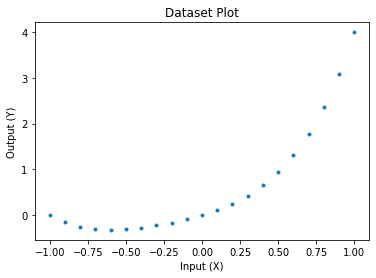

In [3]:
# view data
plt.figure()
plt.plot(X, y, '.')
plt.xlabel('Input (X)')
plt.ylabel('Output (Y)')
plt.title('Dataset Plot')
plt.show()

### Implementing GP Algorithm with the DEAP Framework
Adapted from https://deap.readthedocs.io/en/master/examples/gp_symbreg.html.

In [4]:
import operator
import math
import random

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

Define Helper Functions

In [5]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

In [6]:
def protectedLog(value):
    try:
        return math.log(value)
    except ValueError:
        return 0

In [7]:
def evalSymbReg(individual, points, y=None):
    '''function to evaluate the symbolic regression'''
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    
    # Evalue the sum of absolute error between the expression
    # and the Y values
    errors = (abs(func(points[i]) - y[i]) for i in range(len(points)))
    mae = math.fsum(errors)  
    return mae,

#### Parameter Setting:
population size: 1000,

function set: $\{+, -, *, log, exp, sin, cos, div\}$,

terminal set: x,

number of generations: 50,

crossover probability: 0.7,

mutation probability: 0,

fitness: sum of absolute errors.

In [8]:
# define parameters
pop_size = 1000
gen_num = 50
cross_p = 0.7
mut_p = 0.0

#### Define Function Set (Set of Primitives)

In [9]:
pset = gp.PrimitiveSet("MAIN", 1)

pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(protectedLog, 1)
pset.addPrimitive(math.exp, 1)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(math.cos, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

#### Set up Creator and Toolbox Variables

In [10]:
# define creator variable
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [11]:
# define toolbox variable
toolbox = base.Toolbox()
# register attributes
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalSymbReg, points=X, y=y)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# decorate attributes
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

### Run Algorithm

In [12]:
# set seed
random.seed(318)

# set statistics
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)

# register attributes of statistics
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# define population and HallOfFame
pop = toolbox.population(n=pop_size)
hof = tools.HallOfFame(1)

# define algorithm
pop, log = algorithms.eaSimple(population=pop, toolbox=toolbox, 
                               cxpb=cross_p, mutpb=mut_p, ngen=gen_num, 
                               stats=mstats, halloffame=hof, verbose=True)

   	      	                    fitness                    	                     size                     
   	      	-----------------------------------------------	----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std    	avg  	gen	max	min	nevals	std   
0  	1000  	46.8212	0  	22259.3	4.24698	1000  	703.052	3.358	0  	7  	2  	1000  	1.3863
1  	724   	19.8064	1  	305.473	4.24698	724   	11.7912	3.169	1  	8  	2  	724   	1.32832
2  	682   	17.1991	2  	78.1686	4.24698	682   	6.51992	3.124	2  	9  	2  	682   	1.27461
3  	700   	15.3181	3  	78.1686	4.24698	700   	4.84585	3.041	3  	9  	2  	700   	1.26227
4  	700   	14.2924	4  	40.9435	4.24698	700   	3.72705	3.006	4  	9  	2  	700   	1.2353 
5  	716   	13.8786	5  	40.7796	4.24698	716   	3.817  	3.033	5  	9  	2  	716   	1.29611
6  	664   	13.1444	6  	44.4524	4.24698	664   	4.31889	3.132	6  	9  	2  	664   	1.31931
7  	734   	12.4815	7  	44.4524	2.365  	734   	5.33275	3.475	7  	9  	2  	734   	1.4012 
8  	708

In [13]:
# extract values from log
gen = log.select("gen")
fit_mins = log.chapters["fitness"].select("min")
size_avgs = log.chapters["size"].select("avg")

### Plot Results

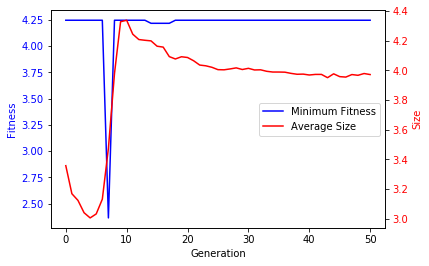

In [14]:
fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, size_avgs, "r-", label="Average Size")
ax2.set_ylabel("Size", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")

plt.savefig("figures/ex8a.png")
plt.show()

### Run Algorithm (with Mutation Rate = 0.1)

In [15]:
# set seed
random.seed(318)

# set new mutation rate
mut_p = 0.1

# set statistics
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)

# register attributes of statistics
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# define population and HallOfFame
pop = toolbox.population(n=pop_size)
hof = tools.HallOfFame(1)

# define algorithm
pop, log = algorithms.eaSimple(population=pop, toolbox=toolbox, 
                               cxpb=cross_p, mutpb=mut_p, ngen=gen_num, 
                               stats=mstats, halloffame=hof, verbose=True)

   	      	                    fitness                    	                     size                     
   	      	-----------------------------------------------	----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std    	avg  	gen	max	min	nevals	std   
0  	1000  	46.8212	0  	22259.3	4.24698	1000  	703.052	3.358	0  	7  	2  	1000  	1.3863
1  	747   	20.7094	1  	305.473	4.24698	747   	15.5447	3.254	1  	11 	1  	747   	1.45859
2  	688   	17.898 	2  	103.702	4.24698	688   	7.86128	3.3  	2  	12 	1  	688   	1.56333
3  	725   	15.7999	3  	78.1686	4.24698	725   	5.56687	3.269	3  	11 	1  	725   	1.52926
4  	721   	15.0689	4  	56.1387	4.21783	721   	5.28652	3.198	4  	11 	1  	721   	1.62259
5  	734   	14.5725	5  	78.1686	4.21783	734   	5.65664	3.237	5  	12 	1  	734   	1.87479
6  	706   	14.5167	6  	98.4403	3.51249	706   	6.84595	3.596	6  	15 	1  	706   	2.28096
7  	745   	14.0308	7  	305.473	3.51249	745   	11.2744	4.119	7  	14 	1  	745   	2.61244
8  	736

In [16]:
# extract values from log
gen = log.select("gen")
fit_mins = log.chapters["fitness"].select("min")
size_avgs = log.chapters["size"].select("avg")

### Plot Results

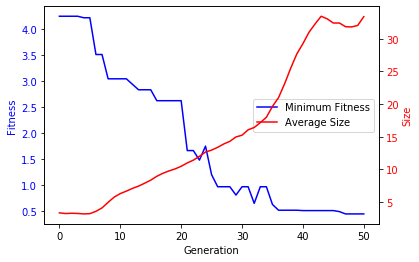

In [17]:
fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, size_avgs, "r-", label="Average Size")
ax2.set_ylabel("Size", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")

plt.savefig("figures/ex8b.png")
plt.show()